In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '94ab940461bd46de858f6731816c7a71')


In [4]:
def search_images_bing(key, term, max_images: int = 150, **kwargs):    
     params = {'q':term, 'count':max_images}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

In [6]:
results = search_images_bing(key, 'dog')
ims = results.attrgot('content_url')
len(ims)

150

In [39]:
dog_types = 'german shepherd','corgi','husky', 'golden retriever', 'shiba inu'
path = Path('dogs')

In [56]:
if not path.exists():
    path.mkdir()
    for o in dog_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} dog')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [57]:
fns = get_image_files(path)
fns

(#445) [Path('dogs/german shepherd/00000047.jpg'),Path('dogs/german shepherd/00000055.jpg'),Path('dogs/german shepherd/00000064.png'),Path('dogs/german shepherd/00000075.jpeg'),Path('dogs/german shepherd/00000107.jpg'),Path('dogs/german shepherd/00000036.jpg'),Path('dogs/german shepherd/00000030.jpg'),Path('dogs/german shepherd/00000097.jpg'),Path('dogs/german shepherd/00000148.jpg'),Path('dogs/german shepherd/00000110.jpg')...]

In [58]:
failed = verify_images(fns)
failed

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


(#0) []

In [59]:
failed.map(Path.unlink);

In [60]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [61]:
dls = dogs.dataloaders(path)

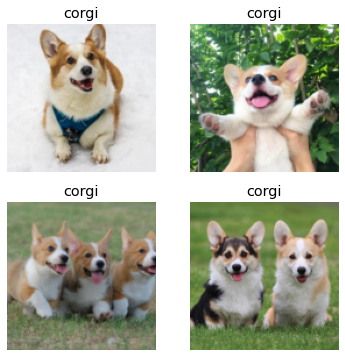

In [62]:
dls.valid.show_batch(max_n=4, nrows=2)

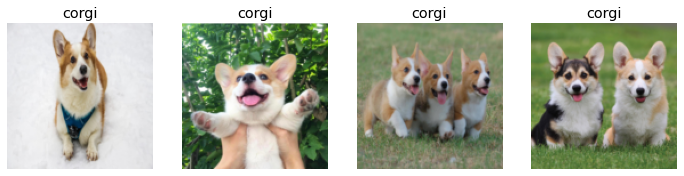

In [63]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

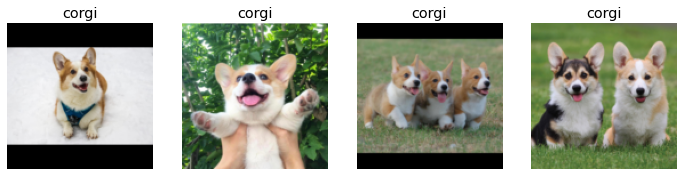

In [64]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

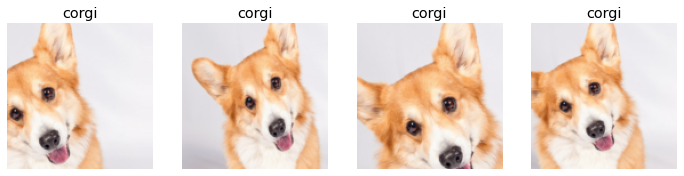

In [65]:
dogs = dogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

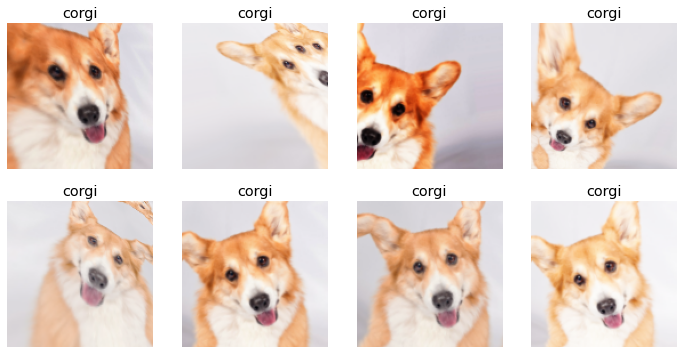

In [66]:
dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [67]:
dogs = dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dogs.dataloaders(path)

In [68]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.296502,0.024946,0.000000,00:10


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


epoch,train_loss,valid_loss,error_rate,time
0,0.196459,0.010169,0.000000,00:10
1,0.116400,0.005724,0.000000,00:10
2,0.088271,0.004907,0.000000,00:11
3,0.069601,0.004695,0.000000,00:10


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


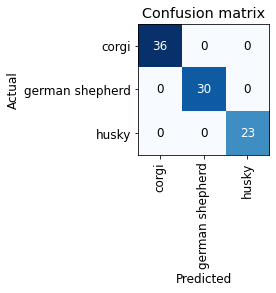

In [69]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

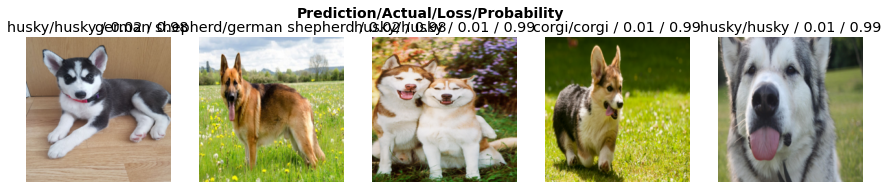

In [22]:
interp.plot_top_losses(5, nrows=1)

In [23]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [24]:
learn.export()

In [25]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [26]:
learn_inf = load_learner(path/'export.pkl')

In [27]:
learn_inf.predict('images/grizzly.jpg')

('german shepherd', tensor(1), tensor([1.2897e-03, 9.9854e-01, 1.6530e-04]))

In [28]:
learn_inf.dls.vocab

['corgi', 'german shepherd', 'husky']

In [29]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [30]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [31]:
img = PILImage.create(btn_upload.data[-1])

In [32]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [33]:
pred,pred_idx,probs = learn_inf.predict(img)

and use a `Label` to display them:

In [34]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: german shepherd; Probability: 0.9985')

`Prediction: grizzly; Probability: 1.0000`

We'll need a button to do the classification. It looks exactly like the upload button:

In [35]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

We'll also need a *click event handler*; that is, a function that will be called when it's pressed. We can just copy over the lines of code from above:

In [36]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

You can test the button now by pressing it, and you should see the image and predictions update automatically!

We can now put them all in a vertical box (`VBox`) to complete our GUI:

In [37]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [38]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

<img alt="The whole widget" width="233" src="images/att_00011.png">

We have written all the code necessary for our app. The next step is to convert it into something we can deploy.

### Turning Your Notebook into a Real App

In [70]:
#hide
#@!pip install voila
#!jupyter serverextension enable --sys-prefix voila 

  Using cached nbconvert-6.0.7-py3-none-any.whl (552 kB)
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbdev 1.1.5 requires nbconvert<6, but you have nbconvert 6.0.7 which is incompatible.
Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.10 OK
